# Single Integral Comparisons
*David Thomas 2017/03/20*

In this notebook we narrow our focus to one individual halo and examine the performance of our likelihood evaluation methods in this single-halo context. Below we have implemented the likelihood integral via numerical integration, simple monte carlo, and with importance sampling. The strange results from importance sampling allowed us to locate an issue and propose a solution for it.

# Table of Contents
- [Abstract](#Single-Integral-Comparisons)
- [Imports](#Imports)
- [Isolate A Halo](#Isolate-A-Halo)
- [Common Methods](#Common-Methods)
- [Numerical Integration](#Numerical-Integration)
- [Simple Monte Carlo](#Simple-Monte-Carlo)
- [Importance Sampling Integration](#Importance-Sampling-Integration)
- [Individual Distribution Evaluations](#Individual-Distribution-Evaluation)
- [Closer Look At Sample Weights](#Closer-Look-At-Sample-Weights)
- [Comparing P2, Q2](#Comparing-P2,-Q2)
- [Key Insight](#Key-Insight)
- [Proposed Solution](#Proposed-Solution)
- [Conclusion](#Conclusion)

# Imports

In [213]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc
from bigmali.grid import Grid
from bigmali.likelihood import BiasedLikelihood
from bigmali.prior import TinkerPrior
from bigmali.hyperparameter import get
from scipy.stats import lognorm
rc('text', usetex=True)

# Isolate A Halo

Here we isolate one halo from our dataset. This is the halo we will focus on in the rest of this analysis.

In [2]:
data = pd.read_csv('/Users/user/Code/PanglossNotebooks/MassLuminosityProject/mock_data.csv')
data.ix[0]

Unnamed: 0    0.000000e+00
gal_id        2.200566e+13
z             2.077090e+00
ra           -1.086232e+02
dec          -1.016961e+02
lum           1.377704e+04
lum_obs       1.374879e+04
mass          1.005246e+11
Name: 0, dtype: float64

In [57]:
true_z = 2.077090e+00
true_lum_obs = 1.374879e+04
true_lum_obs_collection = data.lum_obs

# Common Methods

These are the probability functions that we will need to evaluate in the integrands for the various methods. p is the true probability while q corresponds to our bias distribution for importance sampling.

In [267]:
prior = TinkerPrior(Grid())

def p1(lobs, lum, sigma):
    return fast_lognormal(lum, sigma, lobs)

def p2(lum, mass, a1, a2, a3, a4, S, z):
    mu_lum = np.exp(a1) * ((mass / a3) ** a2) * ((1 + z) ** (a4))
    return fast_lognormal(mu_lum, S, lum)
    
def p3(mass, z):
    return prior.fetch(z).pdf(mass)

def q1(lum, lobs, sigma):
    return fast_lognormal(lobs, sigma, lum)
    
def q2(mass, lum, a1, a2, a3, a4, S, z):
    mu_mass = a3 * (lum / (np.exp(a1) * (1 + z) ** a4)) ** (1 / a2)
    return fast_lognormal(mu_mass, S, mass)

The midpoints is used to turn the mass function into a range to integrate over. The fast_lognormal function is a slightly faster way (vs scipy.stats.lognorm) of evaluating a lognormal.

In [5]:
def midpoints(arr):
    n = len(arr)-1
    ret = np.zeros(n)
    for i in xrange(n):
        ret[i] = (arr[i+1] + arr[i]) / 2.
    return ret

def fast_lognormal(mu, sigma, x):
    return  (1/(x * sigma * np.sqrt(2 * np.pi))) * np.exp(- 0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma ** 2)

We also a point in hyperparameter-space to evaluate our likelihood function on. This configuration is the true value and should maximize the likelihood.

In [ ]:
a1,a2,a3,a4,S = get()

# Numerical Integration

Below is the math behind the computation. One thing to note is that $\Delta_M$ is a function of $M$. This is because the mass function is logscale and the intervals between masses are not constant.

\begin{align*}
\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs}, z) &= \iint\ dLdM\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
&= \sum_{M=min(MP)}^{max(MP)}\sum_{L = min(L_{obs})}^{max(L_{obs})}\ \Delta_M\Delta_L\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
\end{align*}

It is also worth noting that here the mass sample size is capped by 410 samples, the number we have in our mass function. We fix this and let the 'nsamples' parameter control the number of luminosity samples to take from a constant-spaced range from the minimum observed luminosity to the maximum observed luminosity.

In [33]:
def numerical_integration(a1, a2, a3, a4, S, nsamples=10**4):
    masses = midpoints(prior.fetch(true_z).mass)
    delta_masses = np.diff(prior.fetch(true_z).mass)
    lums = np.linspace(np.min(data.lum_obs), np.max(data.lum_obs), nsamples)
    delta_lum = 10.57916582
    sigma = 0.05
    integral = 0
    for lum in lums:
        integral += np.sum(delta_masses * delta_lum * p1(true_lum_obs, lum, sigma) * \
            p2(lum, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z))
    return integral

In [170]:
%time print numerical_integration(a1,a2,a3,a4,S, nsamples=10**5)

0.000112455097023
CPU times: user 12.4 s, sys: 53.3 ms, total: 12.4 s
Wall time: 12.6 s


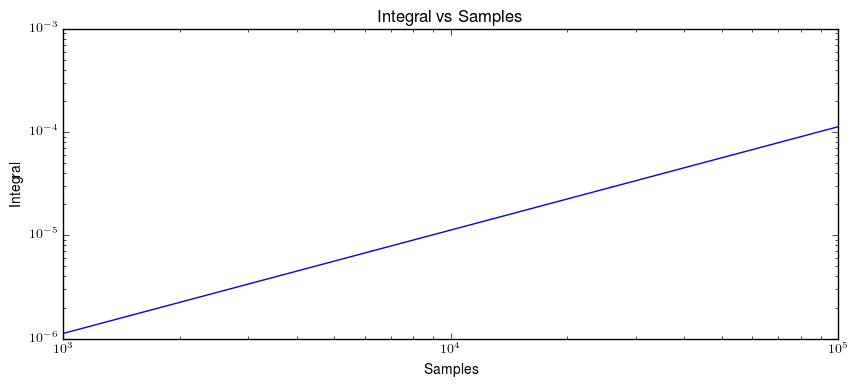

In [278]:
n = 10
vals = np.zeros(n)
logspace = np.logspace(3, 5, n)
for i, nsamples in enumerate(logspace):
    vals[i] = numerical_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    
plt.plot(logspace, vals)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Integral vs Samples')
plt.xlabel('Samples')
plt.ylabel('Integral')
plt.gcf().set_size_inches(10,4);

Here we see that the finer granularity we get over the luminosities the greater the value of the integral. This is suspicious. We suspect this has to do with how we are partitioning the domains of integration and plan to investigate this further in the future. Below is a plot which shows how our luminosity distribution changes with bin size.

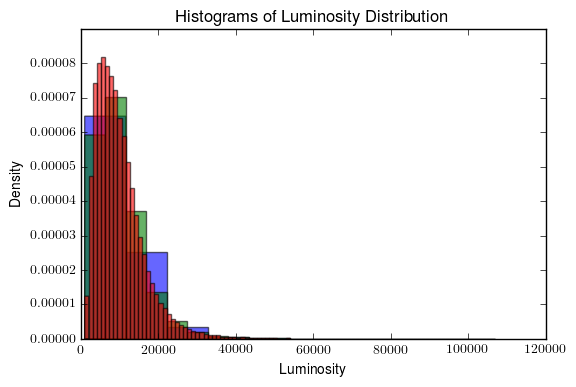

In [233]:
plt.title('Histograms of Luminosity Distribution')
plt.ylabel('Density')
plt.xlabel('Luminosity')
plt.legend()
plt.hist(data.lum, bins=10, alpha=0.6, normed=True, label='bins = 10');
plt.hist(data.lum, bins=20, alpha=0.6, normed=True, label='bins = 20');
plt.hist(data.lum, bins=100, alpha=0.6, normed=True, label='bins = 100');

# Simple Monte Carlo

\begin{align*}
\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs}) &= \iint dLdM\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
&= \frac{1}{N_s}\sum_{M \in\ P(M|z)}\sum_{L \in\ P(L|M, \alpha, S, z)} P(L_{obs}|L, \sigma_{obs})\\
\end{align*}

In [37]:
def simple_monte_carlo_integration(a1, a2, a3, a4, S, nsamples=10**6):
    sigma = 0.05
    masses = prior.fetch(true_z).rvs(nsamples)
    mu_lum = np.exp(a1) * ((masses / a3) ** a2) * ((1 + true_z) ** (a4))
    lums = lognorm(S, scale=mu_lum).rvs()
    return np.sum(p1(true_lum_obs, lums, sigma)) / (nsamples)

#### Linear Runtime as Expected

In [151]:
%time print simple_monte_carlo_integration(a1,a2,a3,a4,S, nsamples=10**4)

1.44531532574e-06
CPU times: user 4.32 ms, sys: 969 µs, total: 5.29 ms
Wall time: 4.01 ms


In [153]:
%time print simple_monte_carlo_integration(a1,a2,a3,a4,S, nsamples=10**7)

1.6867738505e-06
CPU times: user 1.97 s, sys: 364 ms, total: 2.33 s
Wall time: 2.37 s


#### Sensitivity To Sample Size

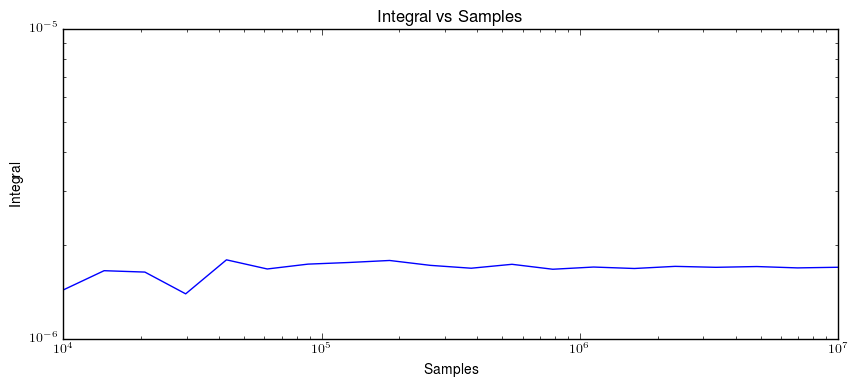

In [277]:
n = 20
vals = np.zeros(n)
logspace = np.logspace(4, 7, n)
for i, nsamples in enumerate(logspace):
    vals[i] = simple_monte_carlo_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    
plt.plot(logspace, vals)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Integral vs Samples')
plt.xlabel('Samples')
plt.ylabel('Integral')
plt.gcf().set_size_inches(10,4)

In the above plot we can see consistent convergence with sample size. We believe this method is accurate and that the true likelihood value is around 1.6e-6.

# Importance Sampling Integration

\begin{align*}
\mathcal{L}(L_{obs}|\alpha_1, \alpha_2, \alpha_3, \alpha_4, S, \sigma_{obs}) &= \iint \frac{P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)Q(M,L)}{Q(M,L)}\\
&= \frac{1}{N_s}\sum_{(M,L) \in\ Q}\frac{P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)}{Q(L|L_{obs}, \sigma_{obs}, c)Q(M|L,\alpha, S, z)}\\
\end{align*}

In [268]:
def importance_sampling_integration(a1, a2, a3, a4, S, nsamples=10**6):
    nsamples = min(nsamples, len(true_lum_obs_collection)-1)
    sigma = 0.05
    rev_sigma = 5.6578015811698101 * sigma
    permuted_lum_obs = np.random.permutation(true_lum_obs_collection)[:nsamples]
    lums = lognorm(sigma, scale=permuted_lum_obs).rvs()
    mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    masses = np.maximum(np.minimum(lognorm(rev_sigma, scale=mu_mass).rvs(), prior.fetch(true_z).max - 1),
                    prior.fetch(true_z).min + 1)
    integral = np.sum((p1(permuted_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
                (q1(lums, permuted_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, S, true_z))) /\
            len(lums)
    return integral

In [269]:
%time ans = importance_sampling_integration(a1,a2,a3,a4,S, nsamples=10**5)

CPU times: user 63 ms, sys: 8.16 ms, total: 71.1 ms
Wall time: 69.2 ms


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


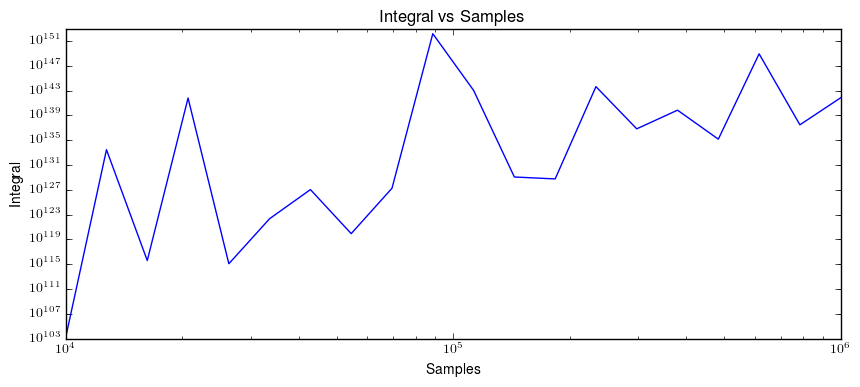

In [286]:
n = 20
vals = np.zeros(n)
logspace = np.logspace(4, 6, n)
for i, nsamples in enumerate(logspace):
    vals[i] = importance_sampling_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    
plt.plot(logspace, vals)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Integral vs Samples')
plt.xlabel('Samples')
plt.ylabel('Integral')
plt.gcf().set_size_inches(10,4);

# Closer Look At Sample Weights

Here we look at the weights of all the samples before they are averaged in the importance sampling integral. Specifically:

$$\frac{P(L_{obs}|L)P(L|M, \alpha, S, \sigma_{obs}, z)P(M|z)}{Q(M,L)}$$

In [199]:
def importance_sampling_integration_samples(a1, a2, a3, a4, S, nsamples=10**6):
    nsamples = min(nsamples, len(true_lum_obs_collection)-1)
    sigma = 0.05
    rev_sigma = 5.6578015811698101 * sigma
    permuted_lum_obs = np.random.permutation(true_lum_obs_collection)[:nsamples]
    lums = lognorm(sigma, scale=permuted_lum_obs).rvs()
    mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    masses = np.maximum(np.minimum(lognorm(rev_sigma, scale=mu_mass).rvs(), prior.fetch(true_z).max - 1),
                    prior.fetch(true_z).min + 1)
    return (p1(permuted_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
                (q1(lums, permuted_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, S, true_z))

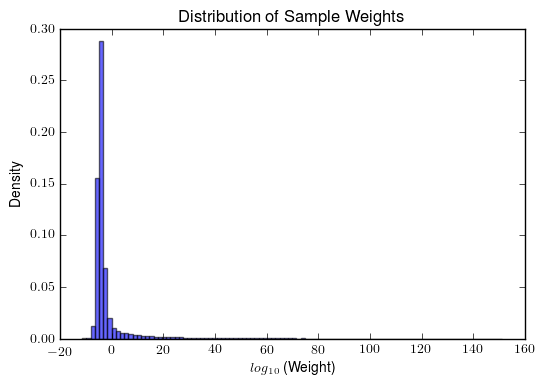

In [211]:
samples = importance_sampling_integration_samples(a1,a2,a3,a4,S, nsamples=10**5)
plt.title('Distribution of Sample Weights')
plt.ylabel('Density')
plt.xlabel('$log_{10}$\ (Weight)')
plt.hist(np.log(samples)/np.log(10), alpha=0.6, bins=100, normed=True);

A few samples with huge weight dominate the integral. A natural next question is why are we getting so many of these extremely high weight samples, when in theory we should be converging to the same value that we got from simple monte carlo integration. Let's look at the individual probability distribution weights:

$$\frac{P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)}{Q(L|L_{obs}, \sigma_{obs}, c)Q(M|L,\alpha, S, z)}$$

# Individual Distribution Evaluations

In [271]:
nsamples = min(nsamples, len(true_lum_obs_collection)-1)
sigma = 0.05
rev_sigma = 5.6578015811698101 * sigma
permuted_lum_obs = np.random.permutation(true_lum_obs_collection)[:nsamples]
lums = lognorm(sigma, scale=permuted_lum_obs).rvs()
mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
masses = np.maximum(np.minimum(lognorm(rev_sigma, scale=mu_mass).rvs(), prior.fetch(true_z).max - 1),
                prior.fetch(true_z).min + 1)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


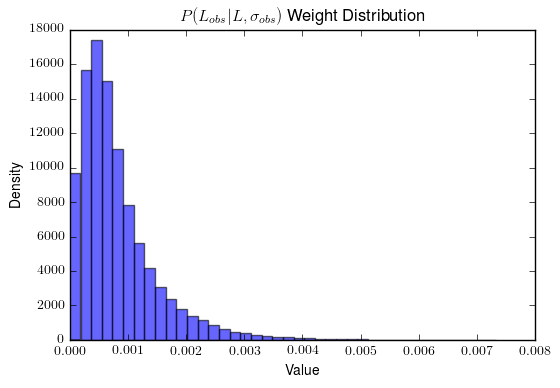

In [241]:
plt.hist(p1(permuted_lum_obs, lums, sigma), bins=40, alpha=0.6)
plt.title('$P(L_{obs}|L, \sigma_{obs})$ Weight Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

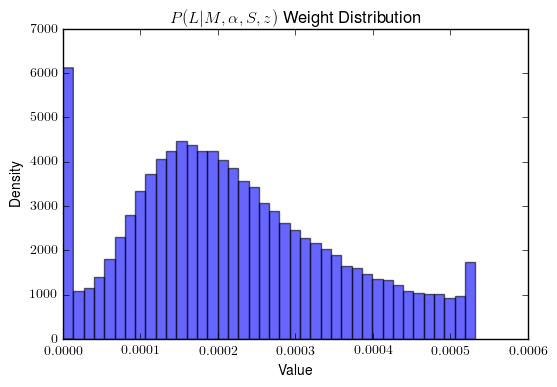

In [244]:
plt.hist(p2(lums, masses, a1, a2, a3, a4, S, true_z), bins=40, alpha=0.6)
plt.title(r'$P(L|M, \alpha, S, z)$ Weight Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

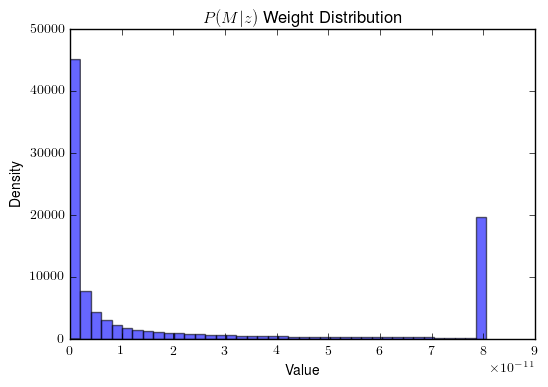

In [246]:
plt.hist(p3(masses, true_z), bins=40, alpha=0.6)
plt.title(r'$P(M|z)$ Weight Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

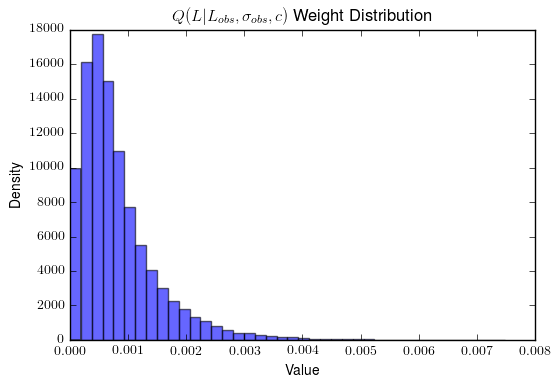

In [250]:
plt.hist(q1(lums, permuted_lum_obs, sigma), bins=40, alpha=0.6)
plt.title('$Q(L|L_{obs}, \sigma_{obs}, c)$ Weight Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

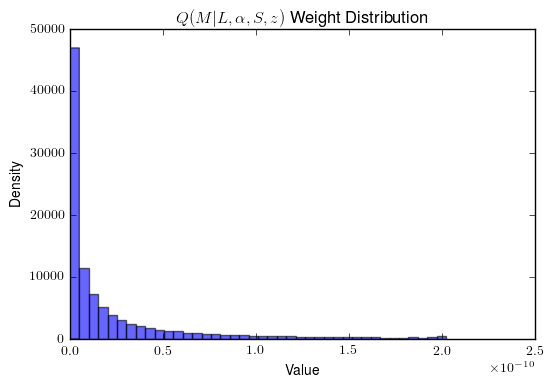

In [272]:
plt.hist(q2(masses, lums, a1, a2, a3, a4, S, true_z), bins=40, alpha=0.6)
plt.title(r'$Q(M|L,\alpha, S, z)$ Weight Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

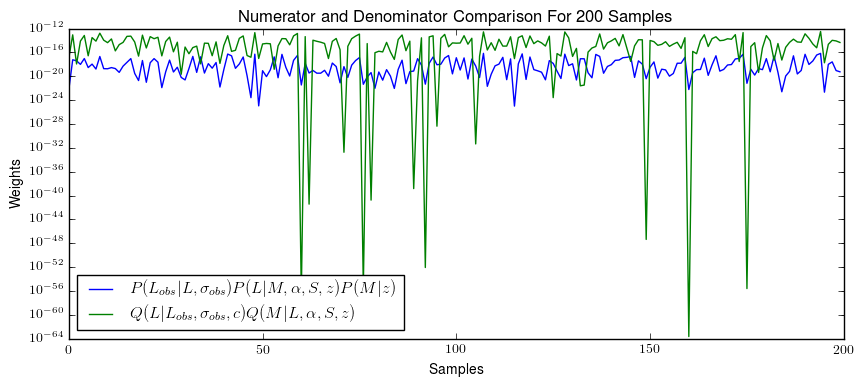

In [282]:
num = (p1(permuted_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z))[:200]
den = (q1(lums, permuted_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, S, true_z))[:200]

plt.plot(num, label=r'$P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)$')
plt.plot(den, label=r'$Q(L|L_{obs}, \sigma_{obs}, c)Q(M|L,\alpha, S, z)$')
plt.gca().set_yscale('log')
plt.legend(loc=3)
plt.gcf().set_size_inches(10,4)
plt.xlabel('Samples')
plt.ylabel('Weights')
plt.title('Numerator and Denominator Comparison For 200 Samples');

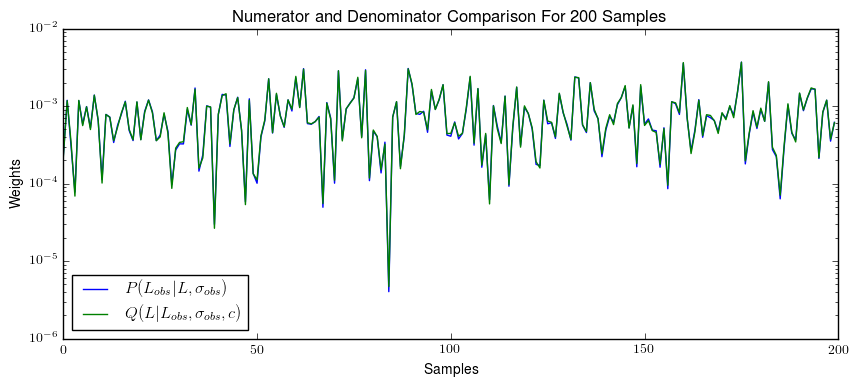

In [283]:
num = p1(permuted_lum_obs, lums, sigma)[:200]
den = q1(lums, permuted_lum_obs, sigma)[:200]

plt.plot(num, label=r'$P(L_{obs}|L, \sigma_{obs})$')
plt.plot(den, label=r'$Q(L|L_{obs}, \sigma_{obs}, c)$')
plt.gca().set_yscale('log')
plt.legend(loc=3)
plt.gcf().set_size_inches(10,4)
plt.xlabel('Samples')
plt.ylabel('Weights')
plt.title('Numerator and Denominator Comparison For 200 Samples');

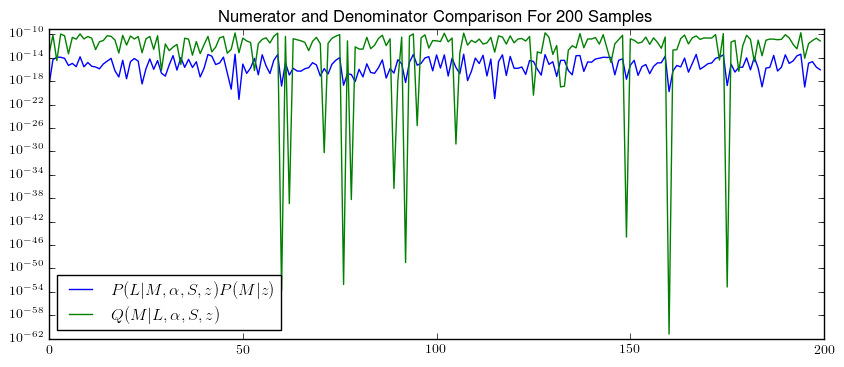

In [285]:
num = (p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z))[:200]
den = (q2(masses, lums, a1, a2, a3, a4, S, true_z))[:200]

plt.plot(num, label=r'$P(L|M, \alpha, S, z)P(M|z)$')
plt.plot(den, label=r'$Q(M|L,\alpha, S, z)$')
plt.gca().set_yscale('log')
plt.legend(loc=3)
plt.gcf().set_size_inches(10,4)
plt.title('Numerator and Denominator Comparison For 200 Samples');

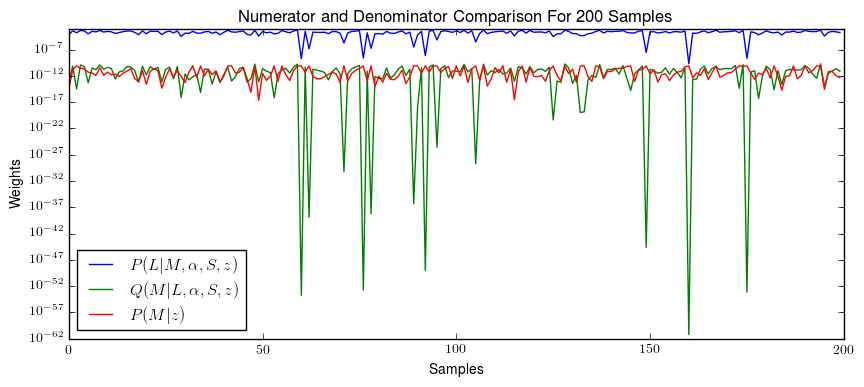

In [284]:
num = (p2(lums, masses, a1, a2, a3, a4, S, true_z))[:200]
den = q2(masses, lums, a1, a2, a3, a4, S, true_z)[:200]


plt.plot(num, label=r'$P(L|M, \alpha, S, z)$')
plt.plot(den, label=r'$Q(M|L,\alpha, S, z)$')
plt.plot(p3(masses, true_z)[:200], label=r'$P(M|z)$')
plt.gca().set_yscale('log')
plt.legend(loc=3)
plt.gcf().set_size_inches(10,4)
plt.xlabel('Samples')
plt.ylabel('Weights')
plt.title('Numerator and Denominator Comparison For 200 Samples');

# Comparing P2, Q2

Clearly we need to look at a few specific halos and see why they generate such different values for the two weight distributions from $P(L|M, \alpha, S, z)$ and $Q(M|L,\alpha, S, z)$.

In [287]:
num = p2(lums, masses, a1, a2, a3, a4, S, true_z)[:200]
den = q2(masses, lums, a1, a2, a3, a4, S, true_z)[:200]

In [292]:
for i, val in enumerate(den):
    if val <= 6.78140024e-52:
        print i

60
76
160
175


In [293]:
masses[60]

12565563000.809088

In [294]:
lums[60]

2148.4357953206936

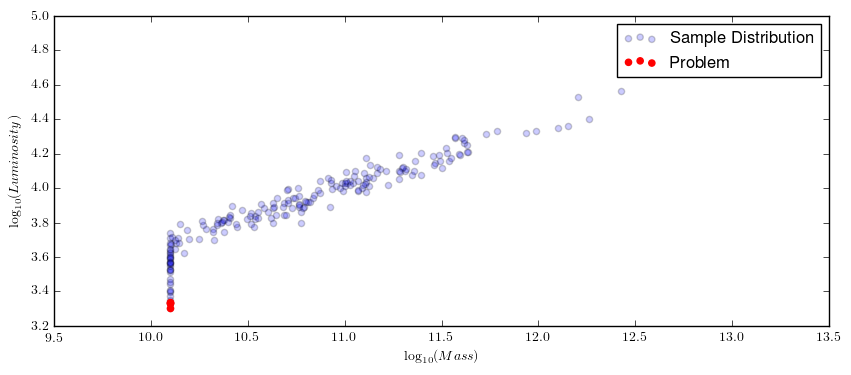

In [314]:
def log10(arr):
    return np.log(arr) / np.log(10)
plt.scatter(log10(masses[:200]), log10(lums[:200]), alpha=0.2, label='Sample Distribution')
plt.scatter(log10(masses[60]), log10(lums[60]), color='red', label='Problem')
plt.scatter(log10(masses[76]), log10(lums[76]), color='red')
plt.scatter(log10(masses[160]), log10(lums[160]), color='red')
plt.scatter(log10(masses[175]), log10(lums[175]), color='red')
plt.xlabel('$\log_{10}(Mass)$')
plt.ylabel('$\log_{10}(Luminosity)$')
plt.gcf().set_size_inches(10,4)
plt.legend();

# Insight

Its a bug! Take a look at the code below. The problem is that the luminosity samples are generated from the observed luminosities. This is a lognormal distribution so there are a few low luminosity outliers, ones that have lower luminosity than any of the observed luminosities. The mass is a function of these luminosities but is capped at the left edge of our mass function distribution, this means that all masses we sample that are less than this edge $m_{min}$ get set to $m_{min}$. The problem is that there is extremely low probability these masses correspond to the outlier luminosity. This is where the crazy spikes are coming from.

In [ ]:
lums = lognorm(sigma, scale=permuted_lum_obs).rvs()
mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
masses = np.maximum(np.minimum(lognorm(rev_sigma, scale=mu_mass).rvs(), prior.fetch(true_z).max - 1),
                prior.fetch(true_z).min + 1)

# Solution
Now that we have determined the issue, the natural next question is how to resolve it. The problem with allowing masses that are outside the range of our mass function is that their probability would be zero, which would preclude us from using logs. We could try to change the mass function prior by adding an 'epsilon background probability' over an extremely large mass range. This would allow us to evaluate masses outside the range while not significantly impacting our sampling. We are going to move forward with this solution.

# Conclusion

In this notebook we located the problem with our previous importance sampling integration. To adress this issue we will be writing a new mass prior with an 'epsilon background'. 